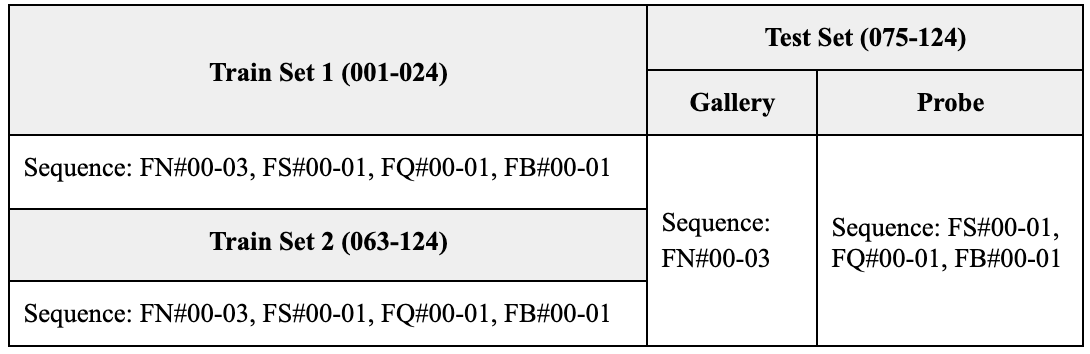

# Distribusi Data Original CASIA-C

In [1]:
import os
import pandas as pd

dataset_path = '/Users/nabilarahmadhani/Documents/project-py/project-casia-b/casia-c'

# Subjek
train_subjects_s1 = [f"{i:03d}" for i in range(1, 25)]     # 001–024
train_subjects_s2 = [f"{i:03d}" for i in range(63, 125)]   # 063–124
test_subjects       = [f"{i:03d}" for i in range(101, 154)] # 101–153

def collect_data(subject_list):
    data = []
    for subject in sorted(subject_list):
        subject_path = os.path.join(dataset_path, subject)
        if not os.path.isdir(subject_path):
            continue
        for condition in os.listdir(subject_path):  # fn00, fb01, etc.
            condition_path = os.path.join(subject_path, condition)
            if not os.path.isdir(condition_path):
                continue
            for file in os.listdir(condition_path):
                if file.endswith('.png'):
                    full_path = os.path.join(subject_path, condition, file)
                    data.append((full_path, subject, condition))
    return data

# Kumpulkan data
data_s1 = collect_data(train_subjects_s1)
data_s2 = collect_data(train_subjects_s2)
data_test = collect_data(test_subjects)

# Simpan ke DataFrame
df_s1 = pd.DataFrame(data_s1, columns=["path", "label", "condition"])
df_s2 = pd.DataFrame(data_s2, columns=["path", "label", "condition"])
df_test = pd.DataFrame(data_test, columns=["path", "label", "condition"])

# Mapping kondisi utama
def map_main_condition(cond):
    return cond[:2]

# Tampilkan distribusi
def show_distribution(df, name=""):
    df['main_condition'] = df['condition'].apply(map_main_condition)
    grouped = df['main_condition'].value_counts().sort_index()
    
    print(f"\nDistribusi data {name} (gabungan kondisi):")
    for cond, count in grouped.items():
        print(f"{cond}: {count}")
    print(f"Total: {len(df)}")

# Output distribusi
show_distribution(df_s1, "Train S1")
show_distribution(df_s2, "Train S2")
show_distribution(df_test, "Test")

print(f"\nJumlah total data: {len(df_s1) + len(df_s2) + len(df_test)}")


Distribusi data Train S1 (gabungan kondisi):
fb: 3113
fn: 6311
fq: 2540
fs: 4276
Total: 16240

Distribusi data Train S2 (gabungan kondisi):
fb: 7747
fn: 15834
fq: 6390
fs: 10747
Total: 40718

Distribusi data Test (gabungan kondisi):
fb: 6736
fn: 13621
fq: 5456
fs: 9397
Total: 35210

Jumlah total data: 92168


In [5]:
import os
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm

dataset_path = '/Users/nabilarahmadhani/Documents/project-py/project-casia-b/casia-c'
output_path = 'split_casia_c'
train_subjects = list(range(1, 25)) + list(range(63, 125))
test_subjects = list(range(25, 63)) + list(range(125, 154))
conditions = ['fn', 'fs', 'fq', 'fb']
MIN_FRAME_THRESHOLD = 30

target_height = 128
target_width = 88

In [6]:
def load_and_stack_images(image_dir, target_height=128, target_width=88):
    files = sorted([f for f in os.listdir(image_dir) if f.endswith('.png')])
    images = []
    for file in files:
        img_path = os.path.join(image_dir, file)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue

        coords = cv2.findNonZero(img)
        if coords is not None:
            x, y, w, h = cv2.boundingRect(coords)
            cropped = img[y:y+h, x:x+w]
        else:
            cropped = img

        h_orig, w_orig = cropped.shape
        scale = target_height / h_orig
        new_w = int(w_orig * scale)
        resized = cv2.resize(cropped, (new_w, target_height), interpolation=cv2.INTER_AREA)

        if new_w < target_width:
            pad_left = (target_width - new_w) // 2
            pad_right = target_width - new_w - pad_left
            resized = cv2.copyMakeBorder(resized, 0, 0, pad_left, pad_right, cv2.BORDER_CONSTANT, value=0)
        elif new_w > target_width:
            offset = (new_w - target_width) // 2
            resized = resized[:, offset:offset+target_width]

        images.append(resized / 255.0)
    return np.array(images) if images else None

def compute_gei(images):
    return np.mean(images, axis=0)

def generate_geis(subjects, split):
    records = []
    for sid in tqdm(subjects, desc=f"Processing {split}"):
        subject_id = f"{sid:03d}"
        subject_path = os.path.join(dataset_path, subject_id)
        if not os.path.exists(subject_path):
            continue

        sequences = sorted(os.listdir(subject_path))
        for seq in sequences:
            frame_dir = os.path.join(subject_path, seq)
            if not os.path.isdir(frame_dir):
                continue

            condition = seq[:2]
            sequence_id = seq[-2:]  # ambil "00", "01", dst
            condition_folder = f"{condition}-{sequence_id}"  # e.g., fb-01

            images = load_and_stack_images(frame_dir)
            if images is None or len(images) < MIN_FRAME_THRESHOLD:
                print(f"Skipping {frame_dir} — only {len(images) if images is not None else 0} frames")
                continue

            gei = compute_gei(images)
            gei_uint8 = (gei * 255).astype(np.uint8)

            # Buat folder output: training/001/fb-01/
            relative_folder = os.path.join(split, subject_id, condition_folder)
            os.makedirs(os.path.join(output_path, relative_folder), exist_ok=True)

            filename = f"{condition_folder}-{seq}.png"
            save_path = os.path.join(output_path, relative_folder, filename)
            success = cv2.imwrite(save_path, gei_uint8)

            if success:
                records.append({
                    "path": os.path.join(relative_folder, filename),
                    "label": subject_id,
                    "condition": condition_folder
                })
    return records

In [14]:
# Generate GEI for train
train_records = generate_geis(train_subjects, "train")
df_train = pd.DataFrame(train_records)
df_train.to_csv(os.path.join(output_path, "train.csv"), index=False, columns=["path", "label", "condition"])

Processing train: 100%|█████████████████████████| 86/86 [00:16<00:00,  5.34it/s]


In [16]:
print("Jumlah baris di CSV:", len(df_train))
print("Jumlah folder train:", len(os.listdir(os.path.join(output_path, "train"))))

Jumlah baris di CSV: 860
Jumlah folder train: 86


In [17]:
# Generate GEI for test
test_records = generate_geis(test_subjects, "test")
df_test = pd.DataFrame(test_records)
df_test.to_csv(os.path.join(output_path, "test.csv"), index=False, columns=["path", "label", "condition"])

Processing test: 100%|██████████████████████████| 67/67 [00:12<00:00,  5.40it/s]


In [18]:
print("Jumlah baris di CSV:", len(df_test))
print("Jumlah folder test:", len(os.listdir(os.path.join(output_path, "test"))))

Jumlah baris di CSV: 670
Jumlah folder test: 67


# Train Keseluruhan

In [3]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from PIL import Image
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from pytorch_metric_learning.samplers import MPerClassSampler
import time
import datetime
import numpy as np
from scipy.spatial.distance import cdist

# === CONFIG ===
CSV_TRAIN = 'split_casia_c/train.csv'
CSV_TEST = 'split_casia_c/test.csv'
IMG_ROOT = 'split_casia_c'
IMG_SIZE = (128, 88)

BATCH_SIZE = 32
EMBED_DIM = 256
MARGIN = 0.4
DROPOUT = 0.3
LR = 1e-3
EPOCHS = 50
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# === TRANSFORMASI ===
transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# === DATASET ===
class GEIDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        img_path = os.path.join(IMG_ROOT, row['path'])
        image = Image.open(img_path).convert('L')
        if self.transform:
            image = self.transform(image)
        label = row['label']
        return image, label

# === MODEL ===
class GEICNN(nn.Module):
    def __init__(self, embedding_dim=256):
        super(GEICNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2),
            
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2),
            
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(kernel_size=2),
            
            nn.AdaptiveAvgPool2d((1, 1))  # Global Average Pooling
        )
        self.embedding = nn.Linear(256, embedding_dim)
        self.dropout = nn.Dropout(p=DROPOUT)
    
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.embedding(x)
        x = self.dropout(x)  # Apply dropout to embedding layer
        return x


# === BATCH-HARD TRIPLET LOSS ===
def batch_hard_triplet_loss(embeddings, labels, margin=0.2):
    pairwise_dist = torch.cdist(embeddings, embeddings, p=2)
    labels = labels.unsqueeze(1)
    mask_pos = (labels == labels.T).float() - torch.eye(labels.size(0), device=embeddings.device)
    mask_neg = (labels != labels.T).float()
    hardest_positive = (pairwise_dist * mask_pos).max(1)[0]
    max_dist = pairwise_dist.max().item()
    masked_neg = pairwise_dist + max_dist * (1.0 - mask_neg)
    hardest_negative = masked_neg.min(1)[0]
    loss = F.relu(hardest_positive - hardest_negative + margin)
    return loss.mean()

In [5]:
def save_checkpoint(model, optimizer, scheduler, epoch, path):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
    }, path)
    print(f"✅ Checkpoint saved to: {path}")

def load_checkpoint(model, optimizer, scheduler, path):
    checkpoint = torch.load(path, map_location=DEVICE)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    print(f"✅ Loaded checkpoint from: {path} (start at epoch {start_epoch})")
    return model, optimizer, scheduler, start_epoch

def train(model_name, resume_path=None):
    df_train = pd.read_csv(CSV_TRAIN)
    df_train['label'] = df_train['label'].astype(int)

    dataset = GEIDataset(df_train, transform=transform)
    sampler = MPerClassSampler(df_train['label'], m=4, length_before_new_iter=len(df_train))
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, sampler=sampler)

    model = GEICNN(embedding_dim=EMBED_DIM).to(DEVICE)

    optimizer = Adam(model.parameters(), lr=LR)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

    start_epoch = 1
    loss_history = []

    # === Resume dari checkpoint jika ada ===
    if resume_path is not None and os.path.isfile(resume_path):
        model, optimizer, scheduler, start_epoch = load_checkpoint(model, optimizer, scheduler, resume_path)
    else:
        print("⚠️ Tidak ada checkpoint, training dari awal.")

    for epoch in range(start_epoch, EPOCHS + 1):
        model.train()
        total_loss = 0
        for images, labels in tqdm(dataloader):
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            embeddings = model(images)
            loss = batch_hard_triplet_loss(embeddings, labels, margin=MARGIN)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)
        loss_history.append(avg_loss)
        scheduler.step(avg_loss)
        print(f"Epoch {epoch}/{EPOCHS}, Loss: {avg_loss:.4f}")

        # Simpan checkpoint setiap epoch
        checkpoint_path = os.path.join('checkpoint_model_casia_c', f"{model_name}_ep{epoch}.pth")
        save_checkpoint(model, optimizer, scheduler, epoch, checkpoint_path)

    # Plot loss curve
    plt.figure(figsize=(8, 5))
    plt.plot(range(start_epoch, EPOCHS + 1), loss_history, marker='o')
    plt.title('Training Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()


In [6]:
# === EVALUATION ===
def extract_embeddings(model, df):
    model.eval()
    embeddings, labels = [], []
    with torch.no_grad():
        for _, row in tqdm(df.iterrows(), total=len(df)):
            img_path = os.path.join(IMG_ROOT, row['path'])
            img = Image.open(img_path).convert('L')
            img_tensor = transform(img).unsqueeze(0).to(DEVICE)
            embedding = model(img_tensor).cpu().numpy().flatten()
            embeddings.append(embedding)
            labels.append(row['label'])
    return np.array(embeddings), np.array(labels)

def evaluate_condition(model_path, save_embeddings=True):
    df_test = pd.read_csv(CSV_TEST)
    df_test['label'] = df_test['label'].astype(int)

    # Gallery = kondisi 'fn-*'
    gallery_df = df_test[df_test['condition'].str.startswith("fn")]

    # Load model
    model = GEICNN(embedding_dim=EMBED_DIM).to(DEVICE)
    checkpoint = torch.load(model_path, map_location=DEVICE)
    model.load_state_dict(checkpoint['model_state_dict'])


    # Embedding gallery
    gallery_embeddings, gallery_labels = extract_embeddings(model, gallery_df)

    if save_embeddings:
        np.save("gallery_embeddings_casia_c.npy", gallery_embeddings)
        np.save("gallery_labels_casia_c.npy", gallery_labels)

    # Probe conditions: fs (slow), fq (fast), fb (bag)
    condition_groups = {
        'fs': df_test[df_test['condition'].str.startswith("fs")],
        'fq': df_test[df_test['condition'].str.startswith("fq")],
        'fb': df_test[df_test['condition'].str.startswith("fb")]
    }

    for group_name, probe_df in condition_groups.items():
        probe_embeddings, probe_labels = extract_embeddings(model, probe_df)

        dists = cdist(probe_embeddings, gallery_embeddings)
        ranks = np.argsort(dists, axis=1)

        correct_rank1 = sum(probe_labels[i] == gallery_labels[ranks[i][0]] for i in range(len(probe_labels)))
        correct_rank5 = sum(probe_labels[i] in gallery_labels[ranks[i][:5]] for i in range(len(probe_labels)))

        rank1 = correct_rank1 / len(probe_labels)
        rank5 = correct_rank5 / len(probe_labels)

        print(f"Rank-1 Accuracy ({group_name}): {rank1:.4f}")
        print(f"Rank-5 Accuracy ({group_name}): {rank5:.4f}")

        if save_embeddings:
            np.save(f"probe_embeddings_casia_c_{group_name}.npy", probe_embeddings)
            np.save(f"probe_labels_casia_c_{group_name}.npy", probe_labels)


# Train Skenario 1

In [3]:
train_subjects_s1 = list(range(1, 25))    # 001–024
train_subjects_s2 = list(range(63, 125))  # 063–124
test_subjects = list(range(101, 154))     # 101–153
output_path = 'split_casia_c_v2'

In [7]:
# Generate GEI for train
train_records_s1 = generate_geis(train_subjects_s1, "train_s1")
df_train_s1 = pd.DataFrame(train_records_s1)
df_train_s1.to_csv(os.path.join(output_path, "train_s1.csv"), index=False, columns=["path", "label", "condition"])

Processing train_s1: 100%|██████████████████████| 24/24 [00:05<00:00,  4.48it/s]


In [11]:
# Generate GEI for train
train_records_s2 = generate_geis(train_subjects_s2, "train_s2")
df_train_s2 = pd.DataFrame(train_records_s2)
df_train_s2.to_csv(os.path.join(output_path, "train_s2.csv"), index=False, columns=["path", "label", "condition"])

Processing train_s2: 100%|██████████████████████| 62/62 [00:11<00:00,  5.55it/s]


In [12]:
# Generate GEI for test
test_records = generate_geis(test_subjects, "test")
df_test = pd.DataFrame(test_records)
df_test.to_csv(os.path.join(output_path, "test.csv"), index=False, columns=["path", "label", "condition"])

Processing test: 100%|██████████████████████████| 53/53 [00:08<00:00,  5.98it/s]


In [142]:
print("Jumlah baris di CSV train skenario 1:", len(df_train_s1))
print("Jumlah baris di CSV train skenario 2:", len(df_train_s2))
print("Jumlah baris di CSV test:", len(df_test))

Jumlah baris di CSV train skenario 1: 240
Jumlah baris di CSV train skenario 2: 620
Jumlah baris di CSV test: 530


In [144]:
# Ekstrak kondisi utama (fb, fn, fq, fs) dari kolom 'condition'
df_train_s1['main_condition'] = df_train_s1['condition'].str[:2]

# Hitung jumlah per kondisi
counts = df_train_s1['main_condition'].value_counts().sort_index()

# Tampilkan hasil
total = len(df_train_s1)
for cond, count in counts.items():
    print(f"{cond}: {count}")
print(f"Total Train Skenario 1: {total}")


fb: 48
fn: 96
fq: 48
fs: 48
Total Train Skenario 1: 240


In [146]:
# Ekstrak kondisi utama (fb, fn, fq, fs) dari kolom 'condition'
df_test['main_condition'] = df_test['condition'].str[:2]

# Hitung jumlah per kondisi
counts = df_test['main_condition'].value_counts().sort_index()

# Tampilkan hasil
total = len(df_test)
for cond, count in counts.items():
    print(f"{cond}: {count}")
print(f"Total Test: {total}")

fb: 106
fn: 212
fq: 106
fs: 106
Total Test: 530


In [ ]:
# Ekstrak kondisi utama (fb, fn, fq, fs) dari kolom 'condition'
df_train_s2['main_condition'] = df_train_s2['condition'].str[:2]

# Hitung jumlah per kondisi
counts = df_train_s2['main_condition'].value_counts().sort_index()

# Tampilkan hasil
total = len(df_train_s2)
for cond, count in counts.items():
    print(f"{cond}: {count}")
print(f"Total Train Skenario 2: {total}")

In [7]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from PIL import Image
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from pytorch_metric_learning.samplers import MPerClassSampler
import time
import datetime
import numpy as np
from scipy.spatial.distance import cdist

# === CONFIG ===
CSV_TRAIN_S1 = 'split_casia_c_v2/train_s1.csv'
CSV_TRAIN_S2 = 'split_casia_c_v2/train_s2.csv'
CSV_TEST = 'split_casia_c_v2/test.csv'
IMG_ROOT = 'split_casia_c_v2'
IMG_SIZE = (128, 88)

BATCH_SIZE = 32
EMBED_DIM = 256
MARGIN = 0.4
DROPOUT = 0.3
LR = 1e-3
EPOCHS = 150
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
class GEICNN(nn.Module):
    def __init__(self, embedding_dim=256):
        super(GEICNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2),
            
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2),
            
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(kernel_size=2),
            
            nn.AdaptiveAvgPool2d((1, 1))  # Output: (B, C, 1, 1)
        )

        # Dummy forward to determine feature dim
        with torch.no_grad():
            dummy = torch.zeros(1, 1, 128, 88)  # GEI shape
            out = self.features(dummy)
            flattened_dim = out.view(1, -1).shape[1]

        self.embedding = nn.Linear(flattened_dim, embedding_dim)
        self.dropout = nn.Dropout(p=DROPOUT)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.embedding(x)
        x = self.dropout(x)
        return x

In [9]:
def train(model_name, CSV, resume_path=None):
    df_train = pd.read_csv(CSV)
    df_train['label'] = df_train['label'].astype(int)

    dataset = GEIDataset(df_train, transform=transform)
    sampler = MPerClassSampler(df_train['label'], m=4, length_before_new_iter=len(df_train))
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, sampler=sampler)

    model = GEICNN(embedding_dim=EMBED_DIM).to(DEVICE)

    optimizer = Adam(model.parameters(), lr=LR)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

    start_epoch = 1
    loss_history = []

    # === Resume dari checkpoint jika ada ===
    if resume_path is not None and os.path.isfile(resume_path):
        model, optimizer, scheduler, start_epoch = load_checkpoint(model, optimizer, scheduler, resume_path)
    else:
        print("⚠️ Tidak ada checkpoint, training dari awal.")

    for epoch in range(start_epoch, EPOCHS + 1):
        model.train()
        total_loss = 0
        for images, labels in tqdm(dataloader):
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            embeddings = model(images)
            loss = batch_hard_triplet_loss(embeddings, labels, margin=MARGIN)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)
        loss_history.append(avg_loss)
        scheduler.step(avg_loss)
        print(f"Epoch {epoch}/{EPOCHS}, Loss: {avg_loss:.4f}")

        # Simpan checkpoint setiap epoch
        checkpoint_path = os.path.join('checkpoint_model_casia_c_v2', f"{model_name}_ep{epoch}.pth")
        save_checkpoint(model, optimizer, scheduler, epoch, checkpoint_path)

    # Plot loss curve
    plt.figure(figsize=(8, 5))
    plt.plot(range(start_epoch, EPOCHS + 1), loss_history, marker='o')
    plt.title('Training Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()


⚠️ Tidak ada checkpoint, training dari awal.


100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.92it/s]


Epoch 1/150, Loss: 1.2702
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S1_cnn_casia_c_ep1.pth


100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.16it/s]


Epoch 2/150, Loss: 0.8347
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S1_cnn_casia_c_ep2.pth


100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.17it/s]


Epoch 3/150, Loss: 0.8029
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S1_cnn_casia_c_ep3.pth


100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.79it/s]


Epoch 4/150, Loss: 0.6758
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S1_cnn_casia_c_ep4.pth


100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.20it/s]


Epoch 5/150, Loss: 0.6409
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S1_cnn_casia_c_ep5.pth


100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.16it/s]


Epoch 6/150, Loss: 0.5068
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S1_cnn_casia_c_ep6.pth


100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.03it/s]


Epoch 7/150, Loss: 0.4684
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S1_cnn_casia_c_ep7.pth


100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.94it/s]


Epoch 8/150, Loss: 0.4632
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S1_cnn_casia_c_ep8.pth


100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.20it/s]


Epoch 9/150, Loss: 0.3907
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S1_cnn_casia_c_ep9.pth


100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.17it/s]


Epoch 10/150, Loss: 0.3520
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S1_cnn_casia_c_ep10.pth


100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.13it/s]


Epoch 11/150, Loss: 0.3543
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S1_cnn_casia_c_ep11.pth


100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.19it/s]


Epoch 12/150, Loss: 0.3319
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S1_cnn_casia_c_ep12.pth


100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.19it/s]


Epoch 13/150, Loss: 0.2870
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S1_cnn_casia_c_ep13.pth


100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.76it/s]


Epoch 14/150, Loss: 0.2996
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S1_cnn_casia_c_ep14.pth


100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.91it/s]


Epoch 15/150, Loss: 0.2930
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S1_cnn_casia_c_ep15.pth


100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.19it/s]


Epoch 16/150, Loss: 0.2805
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S1_cnn_casia_c_ep16.pth


100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.19it/s]


Epoch 17/150, Loss: 0.1990
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S1_cnn_casia_c_ep17.pth


100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.85it/s]


Epoch 18/150, Loss: 0.1868
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S1_cnn_casia_c_ep18.pth


100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.21it/s]


Epoch 19/150, Loss: 0.1403
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S1_cnn_casia_c_ep19.pth


100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.19it/s]


Epoch 20/150, Loss: 0.1479
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S1_cnn_casia_c_ep20.pth


100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.18it/s]


Epoch 21/150, Loss: 0.1129
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S1_cnn_casia_c_ep21.pth


100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.19it/s]


Epoch 22/150, Loss: 0.1619
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S1_cnn_casia_c_ep22.pth


100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.19it/s]


Epoch 23/150, Loss: 0.0650
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S1_cnn_casia_c_ep23.pth


100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.15it/s]


Epoch 24/150, Loss: 0.0449
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S1_cnn_casia_c_ep24.pth


100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.86it/s]


Epoch 25/150, Loss: 0.0493
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S1_cnn_casia_c_ep25.pth


100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.00it/s]


Epoch 26/150, Loss: 0.0304
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S1_cnn_casia_c_ep26.pth


100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.04it/s]


Epoch 27/150, Loss: 0.0658
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S1_cnn_casia_c_ep27.pth


100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.58it/s]


Epoch 28/150, Loss: 0.0384
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S1_cnn_casia_c_ep28.pth


100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.00it/s]


Epoch 29/150, Loss: 0.0518
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S1_cnn_casia_c_ep29.pth


100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.71it/s]


Epoch 30/150, Loss: 0.0464
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S1_cnn_casia_c_ep30.pth


100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.83it/s]


Epoch 31/150, Loss: 0.0294
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S1_cnn_casia_c_ep31.pth


100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.70it/s]


Epoch 32/150, Loss: 0.0351
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S1_cnn_casia_c_ep32.pth


100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.54it/s]


Epoch 33/150, Loss: 0.0138
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S1_cnn_casia_c_ep33.pth


100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.33it/s]


Epoch 34/150, Loss: 0.0089
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S1_cnn_casia_c_ep34.pth


100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.34it/s]


Epoch 35/150, Loss: 0.0080
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S1_cnn_casia_c_ep35.pth


100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.66it/s]


Epoch 36/150, Loss: 0.0094
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S1_cnn_casia_c_ep36.pth


100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.07it/s]


Epoch 37/150, Loss: 0.0118
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S1_cnn_casia_c_ep37.pth


100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.55it/s]


Epoch 38/150, Loss: 0.0113
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S1_cnn_casia_c_ep38.pth


100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.54it/s]


Epoch 39/150, Loss: 0.0143
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S1_cnn_casia_c_ep39.pth


100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.23it/s]


Epoch 40/150, Loss: 0.0006
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S1_cnn_casia_c_ep40.pth


100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.54it/s]


Epoch 41/150, Loss: 0.0044
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S1_cnn_casia_c_ep41.pth


100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.35it/s]


Epoch 42/150, Loss: 0.0011
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S1_cnn_casia_c_ep42.pth


100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.26it/s]


Epoch 43/150, Loss: 0.0011
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S1_cnn_casia_c_ep43.pth


100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.17it/s]


Epoch 44/150, Loss: 0.0030
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S1_cnn_casia_c_ep44.pth


100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.22it/s]


Epoch 45/150, Loss: 0.0042
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S1_cnn_casia_c_ep45.pth


100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.54it/s]


Epoch 46/150, Loss: 0.0003
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S1_cnn_casia_c_ep46.pth


100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.41it/s]


Epoch 47/150, Loss: 0.0004
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S1_cnn_casia_c_ep47.pth


100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.50it/s]


Epoch 48/150, Loss: 0.0030
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S1_cnn_casia_c_ep48.pth


100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.58it/s]


Epoch 49/150, Loss: 0.0019
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S1_cnn_casia_c_ep49.pth


100%|█████████████████████████████████████████████| 6/6 [00:02<00:00,  2.86it/s]


Epoch 50/150, Loss: 0.0021
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S1_cnn_casia_c_ep50.pth


100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.20it/s]


Epoch 51/150, Loss: 0.0000
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S1_cnn_casia_c_ep51.pth


100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.37it/s]


Epoch 52/150, Loss: 0.0018
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S1_cnn_casia_c_ep52.pth


100%|█████████████████████████████████████████████| 6/6 [00:02<00:00,  2.86it/s]


Epoch 53/150, Loss: 0.0008
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S1_cnn_casia_c_ep53.pth


100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.43it/s]


Epoch 54/150, Loss: 0.0000
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S1_cnn_casia_c_ep54.pth


100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.43it/s]


Epoch 55/150, Loss: 0.0003
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S1_cnn_casia_c_ep55.pth


100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.05it/s]


Epoch 56/150, Loss: 0.0001
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S1_cnn_casia_c_ep56.pth


100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.40it/s]


Epoch 57/150, Loss: 0.0031
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S1_cnn_casia_c_ep57.pth


100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.37it/s]


Epoch 58/150, Loss: 0.0010
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S1_cnn_casia_c_ep58.pth


100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.54it/s]


Epoch 59/150, Loss: 0.0004
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S1_cnn_casia_c_ep59.pth


100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.55it/s]


Epoch 60/150, Loss: 0.0014
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S1_cnn_casia_c_ep60.pth


100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.30it/s]


Epoch 61/150, Loss: 0.0033
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S1_cnn_casia_c_ep61.pth


100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.24it/s]


Epoch 62/150, Loss: 0.0005
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S1_cnn_casia_c_ep62.pth


100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.51it/s]


Epoch 63/150, Loss: 0.0042
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S1_cnn_casia_c_ep63.pth


100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.50it/s]


Epoch 64/150, Loss: 0.0032
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S1_cnn_casia_c_ep64.pth


100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.27it/s]


Epoch 65/150, Loss: 0.0018
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S1_cnn_casia_c_ep65.pth


100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.43it/s]


Epoch 66/150, Loss: 0.0000
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S1_cnn_casia_c_ep66.pth


100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.29it/s]


Epoch 67/150, Loss: 0.0004
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S1_cnn_casia_c_ep67.pth


100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.42it/s]


Epoch 68/150, Loss: 0.0017
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S1_cnn_casia_c_ep68.pth


100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.49it/s]


Epoch 69/150, Loss: 0.0001
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S1_cnn_casia_c_ep69.pth


100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.15it/s]


Epoch 70/150, Loss: 0.0013
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S1_cnn_casia_c_ep70.pth


100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.29it/s]


Epoch 71/150, Loss: 0.0006
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S1_cnn_casia_c_ep71.pth


100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.24it/s]


Epoch 72/150, Loss: 0.0024
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S1_cnn_casia_c_ep72.pth


100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.31it/s]


Epoch 73/150, Loss: 0.0009
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S1_cnn_casia_c_ep73.pth


100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.48it/s]


Epoch 74/150, Loss: 0.0017
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S1_cnn_casia_c_ep74.pth


100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.27it/s]


Epoch 75/150, Loss: 0.0000
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S1_cnn_casia_c_ep75.pth


100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.49it/s]


Epoch 76/150, Loss: 0.0000
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S1_cnn_casia_c_ep76.pth


100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.44it/s]


Epoch 77/150, Loss: 0.0013
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S1_cnn_casia_c_ep77.pth


100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.24it/s]


Epoch 78/150, Loss: 0.0000
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S1_cnn_casia_c_ep78.pth


100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.32it/s]


Epoch 79/150, Loss: 0.0000
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S1_cnn_casia_c_ep79.pth


100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.33it/s]


Epoch 80/150, Loss: 0.0012
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S1_cnn_casia_c_ep80.pth


100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.37it/s]


Epoch 81/150, Loss: 0.0000
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S1_cnn_casia_c_ep81.pth


100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.07it/s]


Epoch 82/150, Loss: 0.0011
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S1_cnn_casia_c_ep82.pth


100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.11it/s]


Epoch 83/150, Loss: 0.0028
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S1_cnn_casia_c_ep83.pth


100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.35it/s]


Epoch 84/150, Loss: 0.0032
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S1_cnn_casia_c_ep84.pth


100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.39it/s]


Epoch 85/150, Loss: 0.0000
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S1_cnn_casia_c_ep85.pth


100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.24it/s]


Epoch 86/150, Loss: 0.0012
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S1_cnn_casia_c_ep86.pth


100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.45it/s]


Epoch 87/150, Loss: 0.0016
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S1_cnn_casia_c_ep87.pth


100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.21it/s]


Epoch 88/150, Loss: 0.0021
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S1_cnn_casia_c_ep88.pth


100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.45it/s]


Epoch 89/150, Loss: 0.0013
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S1_cnn_casia_c_ep89.pth


100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.25it/s]


Epoch 90/150, Loss: 0.0061
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S1_cnn_casia_c_ep90.pth


100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.33it/s]


Epoch 91/150, Loss: 0.0009
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S1_cnn_casia_c_ep91.pth


100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.26it/s]


Epoch 92/150, Loss: 0.0006
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S1_cnn_casia_c_ep92.pth


100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.41it/s]


Epoch 93/150, Loss: 0.0010
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S1_cnn_casia_c_ep93.pth


100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.21it/s]


Epoch 94/150, Loss: 0.0000
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S1_cnn_casia_c_ep94.pth


100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.21it/s]


Epoch 95/150, Loss: 0.0011
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S1_cnn_casia_c_ep95.pth


100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.36it/s]


Epoch 96/150, Loss: 0.0006
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S1_cnn_casia_c_ep96.pth


100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.10it/s]


Epoch 97/150, Loss: 0.0016
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S1_cnn_casia_c_ep97.pth


100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.44it/s]


Epoch 98/150, Loss: 0.0040
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S1_cnn_casia_c_ep98.pth


100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.35it/s]


Epoch 99/150, Loss: 0.0013
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S1_cnn_casia_c_ep99.pth


100%|█████████████████████████████████████████████| 6/6 [00:02<00:00,  2.96it/s]


Epoch 100/150, Loss: 0.0005
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S1_cnn_casia_c_ep100.pth


100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.06it/s]


Epoch 101/150, Loss: 0.0011
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S1_cnn_casia_c_ep101.pth


100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.01it/s]


Epoch 102/150, Loss: 0.0003
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S1_cnn_casia_c_ep102.pth


100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.11it/s]


Epoch 103/150, Loss: 0.0019
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S1_cnn_casia_c_ep103.pth


100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.28it/s]


Epoch 104/150, Loss: 0.0001
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S1_cnn_casia_c_ep104.pth


100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.02it/s]


Epoch 105/150, Loss: 0.0033
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S1_cnn_casia_c_ep105.pth


100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.27it/s]


Epoch 106/150, Loss: 0.0008
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S1_cnn_casia_c_ep106.pth


100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.01it/s]


Epoch 107/150, Loss: 0.0021
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S1_cnn_casia_c_ep107.pth


100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.05it/s]


Epoch 108/150, Loss: 0.0015
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S1_cnn_casia_c_ep108.pth


100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.10it/s]


Epoch 109/150, Loss: 0.0001
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S1_cnn_casia_c_ep109.pth


100%|█████████████████████████████████████████████| 6/6 [00:02<00:00,  2.77it/s]


Epoch 110/150, Loss: 0.0019
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S1_cnn_casia_c_ep110.pth


100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.30it/s]


Epoch 111/150, Loss: 0.0003
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S1_cnn_casia_c_ep111.pth


100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.26it/s]


Epoch 112/150, Loss: 0.0027
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S1_cnn_casia_c_ep112.pth


100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.11it/s]


Epoch 113/150, Loss: 0.0001
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S1_cnn_casia_c_ep113.pth


100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.21it/s]


Epoch 114/150, Loss: 0.0014
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S1_cnn_casia_c_ep114.pth


100%|█████████████████████████████████████████████| 6/6 [00:02<00:00,  2.94it/s]


Epoch 115/150, Loss: 0.0000
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S1_cnn_casia_c_ep115.pth


100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.32it/s]


Epoch 116/150, Loss: 0.0007
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S1_cnn_casia_c_ep116.pth


100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.29it/s]


Epoch 117/150, Loss: 0.0003
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S1_cnn_casia_c_ep117.pth


100%|█████████████████████████████████████████████| 6/6 [00:02<00:00,  2.97it/s]


Epoch 118/150, Loss: 0.0036
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S1_cnn_casia_c_ep118.pth


100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.24it/s]


Epoch 119/150, Loss: 0.0008
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S1_cnn_casia_c_ep119.pth


100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.36it/s]


Epoch 120/150, Loss: 0.0000
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S1_cnn_casia_c_ep120.pth


100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.31it/s]


Epoch 121/150, Loss: 0.0015
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S1_cnn_casia_c_ep121.pth


100%|█████████████████████████████████████████████| 6/6 [00:02<00:00,  2.84it/s]


Epoch 122/150, Loss: 0.0000
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S1_cnn_casia_c_ep122.pth


100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.33it/s]


Epoch 123/150, Loss: 0.0003
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S1_cnn_casia_c_ep123.pth


100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.32it/s]


Epoch 124/150, Loss: 0.0008
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S1_cnn_casia_c_ep124.pth


100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.27it/s]


Epoch 125/150, Loss: 0.0000
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S1_cnn_casia_c_ep125.pth


100%|█████████████████████████████████████████████| 6/6 [00:02<00:00,  2.98it/s]


Epoch 126/150, Loss: 0.0019
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S1_cnn_casia_c_ep126.pth


100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.23it/s]


Epoch 127/150, Loss: 0.0018
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S1_cnn_casia_c_ep127.pth


100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.30it/s]


Epoch 128/150, Loss: 0.0001
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S1_cnn_casia_c_ep128.pth


100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.34it/s]


Epoch 129/150, Loss: 0.0000
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S1_cnn_casia_c_ep129.pth


100%|█████████████████████████████████████████████| 6/6 [00:02<00:00,  2.95it/s]


Epoch 130/150, Loss: 0.0005
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S1_cnn_casia_c_ep130.pth


100%|█████████████████████████████████████████████| 6/6 [00:02<00:00,  2.70it/s]


Epoch 131/150, Loss: 0.0005
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S1_cnn_casia_c_ep131.pth


100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.18it/s]


Epoch 132/150, Loss: 0.0006
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S1_cnn_casia_c_ep132.pth


100%|█████████████████████████████████████████████| 6/6 [00:02<00:00,  2.99it/s]


Epoch 133/150, Loss: 0.0019
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S1_cnn_casia_c_ep133.pth


100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.17it/s]


Epoch 134/150, Loss: 0.0000
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S1_cnn_casia_c_ep134.pth


100%|█████████████████████████████████████████████| 6/6 [00:02<00:00,  2.87it/s]


Epoch 135/150, Loss: 0.0001
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S1_cnn_casia_c_ep135.pth


100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.27it/s]


Epoch 136/150, Loss: 0.0000
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S1_cnn_casia_c_ep136.pth


100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.29it/s]


Epoch 137/150, Loss: 0.0000
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S1_cnn_casia_c_ep137.pth


100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.06it/s]


Epoch 138/150, Loss: 0.0006
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S1_cnn_casia_c_ep138.pth


100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.31it/s]


Epoch 139/150, Loss: 0.0020
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S1_cnn_casia_c_ep139.pth


100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.23it/s]


Epoch 140/150, Loss: 0.0000
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S1_cnn_casia_c_ep140.pth


100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.00it/s]


Epoch 141/150, Loss: 0.0023
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S1_cnn_casia_c_ep141.pth


100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.09it/s]


Epoch 142/150, Loss: 0.0002
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S1_cnn_casia_c_ep142.pth


100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.29it/s]


Epoch 143/150, Loss: 0.0046
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S1_cnn_casia_c_ep143.pth


100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.12it/s]


Epoch 144/150, Loss: 0.0000
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S1_cnn_casia_c_ep144.pth


100%|█████████████████████████████████████████████| 6/6 [00:02<00:00,  2.99it/s]


Epoch 145/150, Loss: 0.0000
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S1_cnn_casia_c_ep145.pth


100%|█████████████████████████████████████████████| 6/6 [00:02<00:00,  2.88it/s]


Epoch 146/150, Loss: 0.0005
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S1_cnn_casia_c_ep146.pth


100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.22it/s]


Epoch 147/150, Loss: 0.0010
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S1_cnn_casia_c_ep147.pth


100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.31it/s]


Epoch 148/150, Loss: 0.0000
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S1_cnn_casia_c_ep148.pth


100%|█████████████████████████████████████████████| 6/6 [00:02<00:00,  2.92it/s]


Epoch 149/150, Loss: 0.0004
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S1_cnn_casia_c_ep149.pth


100%|█████████████████████████████████████████████| 6/6 [00:02<00:00,  2.99it/s]

Epoch 150/150, Loss: 0.0010
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S1_cnn_casia_c_ep150.pth


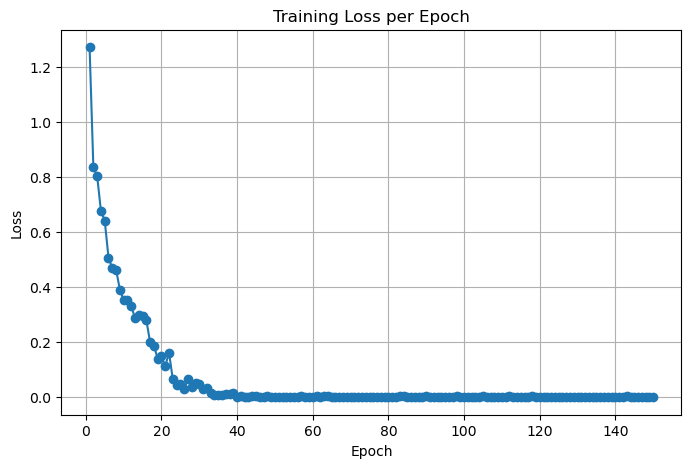


⏱️ Waktu training selesai dalam 269.21 detik (4.49 menit)


In [10]:
if __name__ == '__main__':
    start_time = time.time()
    
    train("S1_cnn_casia_c", CSV_TRAIN_S1)
    
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"\n⏱️ Waktu training selesai dalam {elapsed_time:.2f} detik "
          f"({elapsed_time/60:.2f} menit)")

In [11]:
if __name__ == '__main__':
    start_time = time.time()
    
    evaluate_condition("checkpoint_model_casia_c_v2/S1_cnn_casia_c_ep150.pth")
    
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"\n⏱️ Waktu training selesai dalam {elapsed_time:.2f} detik "
          f"({elapsed_time/60:.2f} menit)")

100%|████████████████████████████████████████| 106/106 [00:00<00:00, 225.65it/s]


Rank-1 Accuracy (fs): 0.6132
Rank-5 Accuracy (fs): 0.7925


100%|████████████████████████████████████████| 106/106 [00:00<00:00, 209.21it/s]


Rank-1 Accuracy (fq): 0.7830
Rank-5 Accuracy (fq): 0.9245


100%|████████████████████████████████████████| 106/106 [00:00<00:00, 185.46it/s]

Rank-1 Accuracy (fb): 0.4151
Rank-5 Accuracy (fb): 0.6321

⏱️ Waktu training selesai dalam 2.84 detik (0.05 menit)


# Skenario 2

In [135]:
EPOCHS = 150

In [136]:
class GEICNN(nn.Module):
    def __init__(self, embedding_dim=256):
        super(GEICNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2),
            
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2),
            
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2),
            
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(kernel_size=2),
            
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(kernel_size=2),
            
            nn.AdaptiveAvgPool2d((1, 1))  # Output: (B, C, 1, 1)
        )

        # Dummy forward to determine feature dim
        with torch.no_grad():
            dummy = torch.zeros(1, 1, 128, 88)  # GEI shape
            out = self.features(dummy)
            flattened_dim = out.view(1, -1).shape[1]

        self.embedding = nn.Linear(flattened_dim, embedding_dim)
        self.dropout = nn.Dropout(p=DROPOUT)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.embedding(x)
        x = self.dropout(x)
        return x

⚠️ Tidak ada checkpoint, training dari awal.


100%|███████████████████████████████████████████| 16/16 [00:03<00:00,  4.02it/s]


Epoch 1/150, Loss: 1.3695
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S2_cnn_casia_c_ep1.pth


100%|███████████████████████████████████████████| 16/16 [00:03<00:00,  4.07it/s]


Epoch 2/150, Loss: 1.0528
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S2_cnn_casia_c_ep2.pth


100%|███████████████████████████████████████████| 16/16 [00:04<00:00,  3.95it/s]


Epoch 3/150, Loss: 0.7873
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S2_cnn_casia_c_ep3.pth


100%|███████████████████████████████████████████| 16/16 [00:04<00:00,  3.91it/s]


Epoch 4/150, Loss: 0.6904
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S2_cnn_casia_c_ep4.pth


100%|███████████████████████████████████████████| 16/16 [00:03<00:00,  4.01it/s]


Epoch 5/150, Loss: 0.7740
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S2_cnn_casia_c_ep5.pth


100%|███████████████████████████████████████████| 16/16 [00:04<00:00,  3.66it/s]


Epoch 6/150, Loss: 0.5381
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S2_cnn_casia_c_ep6.pth


100%|███████████████████████████████████████████| 16/16 [00:04<00:00,  3.38it/s]


Epoch 7/150, Loss: 0.6188
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S2_cnn_casia_c_ep7.pth


100%|███████████████████████████████████████████| 16/16 [00:04<00:00,  3.87it/s]


Epoch 8/150, Loss: 0.5707
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S2_cnn_casia_c_ep8.pth


100%|███████████████████████████████████████████| 16/16 [00:04<00:00,  3.82it/s]


Epoch 9/150, Loss: 0.4627
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S2_cnn_casia_c_ep9.pth


100%|███████████████████████████████████████████| 16/16 [00:04<00:00,  3.70it/s]


Epoch 10/150, Loss: 0.4315
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S2_cnn_casia_c_ep10.pth


100%|███████████████████████████████████████████| 16/16 [00:04<00:00,  3.64it/s]


Epoch 11/150, Loss: 0.4546
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S2_cnn_casia_c_ep11.pth


100%|███████████████████████████████████████████| 16/16 [00:04<00:00,  3.62it/s]


Epoch 12/150, Loss: 0.4361
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S2_cnn_casia_c_ep12.pth


100%|███████████████████████████████████████████| 16/16 [00:04<00:00,  3.65it/s]


Epoch 13/150, Loss: 0.3303
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S2_cnn_casia_c_ep13.pth


100%|███████████████████████████████████████████| 16/16 [00:04<00:00,  3.48it/s]


Epoch 14/150, Loss: 0.3145
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S2_cnn_casia_c_ep14.pth


100%|███████████████████████████████████████████| 16/16 [00:04<00:00,  3.51it/s]


Epoch 15/150, Loss: 0.3799
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S2_cnn_casia_c_ep15.pth


100%|███████████████████████████████████████████| 16/16 [00:04<00:00,  3.41it/s]


Epoch 16/150, Loss: 0.3229
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S2_cnn_casia_c_ep16.pth


100%|███████████████████████████████████████████| 16/16 [00:04<00:00,  3.41it/s]


Epoch 17/150, Loss: 0.2634
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S2_cnn_casia_c_ep17.pth


100%|███████████████████████████████████████████| 16/16 [00:04<00:00,  3.44it/s]


Epoch 18/150, Loss: 0.3008
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S2_cnn_casia_c_ep18.pth


100%|███████████████████████████████████████████| 16/16 [00:04<00:00,  3.47it/s]


Epoch 19/150, Loss: 0.2847
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S2_cnn_casia_c_ep19.pth


100%|███████████████████████████████████████████| 16/16 [00:04<00:00,  3.49it/s]


Epoch 20/150, Loss: 0.2126
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S2_cnn_casia_c_ep20.pth


100%|███████████████████████████████████████████| 16/16 [00:04<00:00,  3.34it/s]


Epoch 21/150, Loss: 0.1712
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S2_cnn_casia_c_ep21.pth


100%|███████████████████████████████████████████| 16/16 [00:04<00:00,  3.24it/s]


Epoch 22/150, Loss: 0.2644
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S2_cnn_casia_c_ep22.pth


100%|███████████████████████████████████████████| 16/16 [00:04<00:00,  3.32it/s]


Epoch 23/150, Loss: 0.2321
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S2_cnn_casia_c_ep23.pth


100%|███████████████████████████████████████████| 16/16 [00:04<00:00,  3.22it/s]


Epoch 24/150, Loss: 0.1890
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S2_cnn_casia_c_ep24.pth


100%|███████████████████████████████████████████| 16/16 [00:04<00:00,  3.37it/s]


Epoch 25/150, Loss: 0.3297
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S2_cnn_casia_c_ep25.pth


100%|███████████████████████████████████████████| 16/16 [00:04<00:00,  3.26it/s]


Epoch 26/150, Loss: 0.2739
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S2_cnn_casia_c_ep26.pth


100%|███████████████████████████████████████████| 16/16 [00:04<00:00,  3.28it/s]


Epoch 27/150, Loss: 0.1386
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S2_cnn_casia_c_ep27.pth


100%|███████████████████████████████████████████| 16/16 [00:04<00:00,  3.36it/s]


Epoch 28/150, Loss: 0.0950
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S2_cnn_casia_c_ep28.pth


100%|███████████████████████████████████████████| 16/16 [00:05<00:00,  2.88it/s]


Epoch 29/150, Loss: 0.1359
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S2_cnn_casia_c_ep29.pth


100%|███████████████████████████████████████████| 16/16 [00:05<00:00,  3.10it/s]


Epoch 30/150, Loss: 0.2436
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S2_cnn_casia_c_ep30.pth


100%|███████████████████████████████████████████| 16/16 [00:04<00:00,  3.28it/s]


Epoch 31/150, Loss: 0.1779
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S2_cnn_casia_c_ep31.pth


100%|███████████████████████████████████████████| 16/16 [00:04<00:00,  3.23it/s]


Epoch 32/150, Loss: 0.1332
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S2_cnn_casia_c_ep32.pth


100%|███████████████████████████████████████████| 16/16 [00:05<00:00,  3.11it/s]


Epoch 33/150, Loss: 0.1082
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S2_cnn_casia_c_ep33.pth


100%|███████████████████████████████████████████| 16/16 [00:04<00:00,  3.28it/s]


Epoch 34/150, Loss: 0.0793
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S2_cnn_casia_c_ep34.pth


100%|███████████████████████████████████████████| 16/16 [00:04<00:00,  3.21it/s]


Epoch 35/150, Loss: 0.0958
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S2_cnn_casia_c_ep35.pth


100%|███████████████████████████████████████████| 16/16 [00:04<00:00,  3.21it/s]


Epoch 36/150, Loss: 0.0761
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S2_cnn_casia_c_ep36.pth


100%|███████████████████████████████████████████| 16/16 [00:04<00:00,  3.30it/s]


Epoch 37/150, Loss: 0.0659
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S2_cnn_casia_c_ep37.pth


100%|███████████████████████████████████████████| 16/16 [00:04<00:00,  3.31it/s]


Epoch 38/150, Loss: 0.0743
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S2_cnn_casia_c_ep38.pth


100%|███████████████████████████████████████████| 16/16 [00:04<00:00,  3.22it/s]


Epoch 39/150, Loss: 0.0738
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S2_cnn_casia_c_ep39.pth


100%|███████████████████████████████████████████| 16/16 [00:04<00:00,  3.32it/s]


Epoch 40/150, Loss: 0.0386
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S2_cnn_casia_c_ep40.pth


100%|███████████████████████████████████████████| 16/16 [00:04<00:00,  3.22it/s]


Epoch 41/150, Loss: 0.0417
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S2_cnn_casia_c_ep41.pth


100%|███████████████████████████████████████████| 16/16 [00:04<00:00,  3.21it/s]


Epoch 42/150, Loss: 0.0498
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S2_cnn_casia_c_ep42.pth


100%|███████████████████████████████████████████| 16/16 [00:04<00:00,  3.30it/s]


Epoch 43/150, Loss: 0.0447
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S2_cnn_casia_c_ep43.pth


100%|███████████████████████████████████████████| 16/16 [00:04<00:00,  3.30it/s]


Epoch 44/150, Loss: 0.0334
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S2_cnn_casia_c_ep44.pth


100%|███████████████████████████████████████████| 16/16 [00:04<00:00,  3.21it/s]


Epoch 45/150, Loss: 0.0346
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S2_cnn_casia_c_ep45.pth


100%|███████████████████████████████████████████| 16/16 [00:04<00:00,  3.30it/s]


Epoch 46/150, Loss: 0.0488
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S2_cnn_casia_c_ep46.pth


100%|███████████████████████████████████████████| 16/16 [00:04<00:00,  3.22it/s]


Epoch 47/150, Loss: 0.0262
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S2_cnn_casia_c_ep47.pth


100%|███████████████████████████████████████████| 16/16 [00:05<00:00,  3.11it/s]


Epoch 48/150, Loss: 0.0269
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S2_cnn_casia_c_ep48.pth


100%|███████████████████████████████████████████| 16/16 [00:04<00:00,  3.31it/s]


Epoch 49/150, Loss: 0.0391
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S2_cnn_casia_c_ep49.pth


100%|███████████████████████████████████████████| 16/16 [00:04<00:00,  3.36it/s]


Epoch 50/150, Loss: 0.0305
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S2_cnn_casia_c_ep50.pth


100%|███████████████████████████████████████████| 16/16 [00:04<00:00,  3.25it/s]


Epoch 51/150, Loss: 0.0204
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S2_cnn_casia_c_ep51.pth


100%|███████████████████████████████████████████| 16/16 [00:04<00:00,  3.34it/s]


Epoch 52/150, Loss: 0.0204
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S2_cnn_casia_c_ep52.pth


100%|███████████████████████████████████████████| 16/16 [00:05<00:00,  3.19it/s]


Epoch 53/150, Loss: 0.0279
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S2_cnn_casia_c_ep53.pth


100%|███████████████████████████████████████████| 16/16 [00:04<00:00,  3.23it/s]


Epoch 54/150, Loss: 0.0304
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S2_cnn_casia_c_ep54.pth


100%|███████████████████████████████████████████| 16/16 [00:04<00:00,  3.32it/s]


Epoch 55/150, Loss: 0.0097
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S2_cnn_casia_c_ep55.pth


100%|███████████████████████████████████████████| 16/16 [00:04<00:00,  3.31it/s]


Epoch 56/150, Loss: 0.0266
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S2_cnn_casia_c_ep56.pth


100%|███████████████████████████████████████████| 16/16 [00:05<00:00,  3.19it/s]


Epoch 57/150, Loss: 0.0202
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S2_cnn_casia_c_ep57.pth


100%|███████████████████████████████████████████| 16/16 [00:05<00:00,  3.15it/s]


Epoch 58/150, Loss: 0.0348
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S2_cnn_casia_c_ep58.pth


100%|███████████████████████████████████████████| 16/16 [00:05<00:00,  3.18it/s]


Epoch 59/150, Loss: 0.0260
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S2_cnn_casia_c_ep59.pth


100%|███████████████████████████████████████████| 16/16 [00:05<00:00,  3.11it/s]


Epoch 60/150, Loss: 0.0057
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S2_cnn_casia_c_ep60.pth


100%|███████████████████████████████████████████| 16/16 [00:04<00:00,  3.26it/s]


Epoch 61/150, Loss: 0.0160
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S2_cnn_casia_c_ep61.pth


100%|███████████████████████████████████████████| 16/16 [00:04<00:00,  3.25it/s]


Epoch 62/150, Loss: 0.0262
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S2_cnn_casia_c_ep62.pth


100%|███████████████████████████████████████████| 16/16 [00:05<00:00,  3.17it/s]


Epoch 63/150, Loss: 0.0143
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S2_cnn_casia_c_ep63.pth


100%|███████████████████████████████████████████| 16/16 [00:04<00:00,  3.25it/s]


Epoch 64/150, Loss: 0.0183
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S2_cnn_casia_c_ep64.pth


100%|███████████████████████████████████████████| 16/16 [00:05<00:00,  3.15it/s]


Epoch 65/150, Loss: 0.0171
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S2_cnn_casia_c_ep65.pth


100%|███████████████████████████████████████████| 16/16 [00:05<00:00,  3.13it/s]


Epoch 66/150, Loss: 0.0258
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S2_cnn_casia_c_ep66.pth


100%|███████████████████████████████████████████| 16/16 [00:04<00:00,  3.27it/s]


Epoch 67/150, Loss: 0.0171
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S2_cnn_casia_c_ep67.pth


100%|███████████████████████████████████████████| 16/16 [00:04<00:00,  3.28it/s]


Epoch 68/150, Loss: 0.0161
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S2_cnn_casia_c_ep68.pth


100%|███████████████████████████████████████████| 16/16 [00:05<00:00,  3.09it/s]


Epoch 69/150, Loss: 0.0063
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S2_cnn_casia_c_ep69.pth


100%|███████████████████████████████████████████| 16/16 [00:05<00:00,  3.05it/s]


Epoch 70/150, Loss: 0.0057
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S2_cnn_casia_c_ep70.pth


100%|███████████████████████████████████████████| 16/16 [00:05<00:00,  3.11it/s]


Epoch 71/150, Loss: 0.0024
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S2_cnn_casia_c_ep71.pth


100%|███████████████████████████████████████████| 16/16 [00:05<00:00,  3.13it/s]


Epoch 72/150, Loss: 0.0086
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S2_cnn_casia_c_ep72.pth


100%|███████████████████████████████████████████| 16/16 [00:05<00:00,  3.14it/s]


Epoch 73/150, Loss: 0.0201
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S2_cnn_casia_c_ep73.pth


100%|███████████████████████████████████████████| 16/16 [00:05<00:00,  3.19it/s]


Epoch 74/150, Loss: 0.0107
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S2_cnn_casia_c_ep74.pth


100%|███████████████████████████████████████████| 16/16 [00:05<00:00,  3.13it/s]


Epoch 75/150, Loss: 0.0097
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S2_cnn_casia_c_ep75.pth


100%|███████████████████████████████████████████| 16/16 [00:04<00:00,  3.23it/s]


Epoch 76/150, Loss: 0.0109
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S2_cnn_casia_c_ep76.pth


100%|███████████████████████████████████████████| 16/16 [00:05<00:00,  3.06it/s]


Epoch 77/150, Loss: 0.0198
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S2_cnn_casia_c_ep77.pth


100%|███████████████████████████████████████████| 16/16 [00:05<00:00,  3.16it/s]


Epoch 78/150, Loss: 0.0085
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S2_cnn_casia_c_ep78.pth


100%|███████████████████████████████████████████| 16/16 [00:04<00:00,  3.21it/s]


Epoch 79/150, Loss: 0.0116
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S2_cnn_casia_c_ep79.pth


100%|███████████████████████████████████████████| 16/16 [00:05<00:00,  3.03it/s]


Epoch 80/150, Loss: 0.0143
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S2_cnn_casia_c_ep80.pth


100%|███████████████████████████████████████████| 16/16 [00:04<00:00,  3.23it/s]


Epoch 81/150, Loss: 0.0050
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S2_cnn_casia_c_ep81.pth


100%|███████████████████████████████████████████| 16/16 [00:05<00:00,  3.12it/s]


Epoch 82/150, Loss: 0.0165
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S2_cnn_casia_c_ep82.pth


100%|███████████████████████████████████████████| 16/16 [00:05<00:00,  2.95it/s]


Epoch 83/150, Loss: 0.0079
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S2_cnn_casia_c_ep83.pth


100%|███████████████████████████████████████████| 16/16 [00:05<00:00,  3.03it/s]


Epoch 84/150, Loss: 0.0099
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S2_cnn_casia_c_ep84.pth


100%|███████████████████████████████████████████| 16/16 [00:04<00:00,  3.22it/s]


Epoch 85/150, Loss: 0.0048
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S2_cnn_casia_c_ep85.pth


100%|███████████████████████████████████████████| 16/16 [00:05<00:00,  3.13it/s]


Epoch 86/150, Loss: 0.0042
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S2_cnn_casia_c_ep86.pth


100%|███████████████████████████████████████████| 16/16 [00:05<00:00,  3.11it/s]


Epoch 87/150, Loss: 0.0191
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S2_cnn_casia_c_ep87.pth


100%|███████████████████████████████████████████| 16/16 [00:05<00:00,  3.03it/s]


Epoch 88/150, Loss: 0.0048
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S2_cnn_casia_c_ep88.pth


100%|███████████████████████████████████████████| 16/16 [00:05<00:00,  3.04it/s]


Epoch 89/150, Loss: 0.0061
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S2_cnn_casia_c_ep89.pth


100%|███████████████████████████████████████████| 16/16 [00:05<00:00,  3.17it/s]


Epoch 90/150, Loss: 0.0097
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S2_cnn_casia_c_ep90.pth


100%|███████████████████████████████████████████| 16/16 [00:05<00:00,  3.17it/s]


Epoch 91/150, Loss: 0.0063
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S2_cnn_casia_c_ep91.pth


100%|███████████████████████████████████████████| 16/16 [00:05<00:00,  3.05it/s]


Epoch 92/150, Loss: 0.0181
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S2_cnn_casia_c_ep92.pth


100%|███████████████████████████████████████████| 16/16 [00:04<00:00,  3.23it/s]


Epoch 93/150, Loss: 0.0168
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S2_cnn_casia_c_ep93.pth


100%|███████████████████████████████████████████| 16/16 [00:05<00:00,  3.12it/s]


Epoch 94/150, Loss: 0.0031
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S2_cnn_casia_c_ep94.pth


100%|███████████████████████████████████████████| 16/16 [00:05<00:00,  3.08it/s]


Epoch 95/150, Loss: 0.0017
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S2_cnn_casia_c_ep95.pth


100%|███████████████████████████████████████████| 16/16 [00:05<00:00,  3.18it/s]


Epoch 96/150, Loss: 0.0033
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S2_cnn_casia_c_ep96.pth


100%|███████████████████████████████████████████| 16/16 [00:05<00:00,  3.20it/s]


Epoch 97/150, Loss: 0.0069
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S2_cnn_casia_c_ep97.pth


100%|███████████████████████████████████████████| 16/16 [00:05<00:00,  3.08it/s]


Epoch 98/150, Loss: 0.0051
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S2_cnn_casia_c_ep98.pth


100%|███████████████████████████████████████████| 16/16 [00:05<00:00,  3.16it/s]


Epoch 99/150, Loss: 0.0058
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S2_cnn_casia_c_ep99.pth


100%|███████████████████████████████████████████| 16/16 [00:05<00:00,  3.07it/s]


Epoch 100/150, Loss: 0.0062
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S2_cnn_casia_c_ep100.pth


100%|███████████████████████████████████████████| 16/16 [00:05<00:00,  3.11it/s]


Epoch 101/150, Loss: 0.0223
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S2_cnn_casia_c_ep101.pth


100%|███████████████████████████████████████████| 16/16 [00:05<00:00,  3.14it/s]


Epoch 102/150, Loss: 0.0061
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S2_cnn_casia_c_ep102.pth


100%|███████████████████████████████████████████| 16/16 [00:05<00:00,  3.19it/s]


Epoch 103/150, Loss: 0.0135
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S2_cnn_casia_c_ep103.pth


100%|███████████████████████████████████████████| 16/16 [00:05<00:00,  3.09it/s]


Epoch 104/150, Loss: 0.0176
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S2_cnn_casia_c_ep104.pth


100%|███████████████████████████████████████████| 16/16 [00:05<00:00,  3.09it/s]


Epoch 105/150, Loss: 0.0078
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S2_cnn_casia_c_ep105.pth


100%|███████████████████████████████████████████| 16/16 [00:05<00:00,  3.04it/s]


Epoch 106/150, Loss: 0.0181
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S2_cnn_casia_c_ep106.pth


100%|███████████████████████████████████████████| 16/16 [00:05<00:00,  3.19it/s]


Epoch 107/150, Loss: 0.0195
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S2_cnn_casia_c_ep107.pth


100%|███████████████████████████████████████████| 16/16 [00:05<00:00,  3.16it/s]


Epoch 108/150, Loss: 0.0046
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S2_cnn_casia_c_ep108.pth


100%|███████████████████████████████████████████| 16/16 [00:05<00:00,  3.13it/s]


Epoch 109/150, Loss: 0.0118
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S2_cnn_casia_c_ep109.pth


100%|███████████████████████████████████████████| 16/16 [00:04<00:00,  3.21it/s]


Epoch 110/150, Loss: 0.0062
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S2_cnn_casia_c_ep110.pth


100%|███████████████████████████████████████████| 16/16 [00:05<00:00,  3.05it/s]


Epoch 111/150, Loss: 0.0197
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S2_cnn_casia_c_ep111.pth


100%|███████████████████████████████████████████| 16/16 [00:05<00:00,  3.07it/s]


Epoch 112/150, Loss: 0.0033
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S2_cnn_casia_c_ep112.pth


100%|███████████████████████████████████████████| 16/16 [00:05<00:00,  3.18it/s]


Epoch 113/150, Loss: 0.0018
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S2_cnn_casia_c_ep113.pth


100%|███████████████████████████████████████████| 16/16 [00:05<00:00,  3.17it/s]


Epoch 114/150, Loss: 0.0131
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S2_cnn_casia_c_ep114.pth


100%|███████████████████████████████████████████| 16/16 [00:05<00:00,  3.09it/s]


Epoch 115/150, Loss: 0.0118
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S2_cnn_casia_c_ep115.pth


100%|███████████████████████████████████████████| 16/16 [00:05<00:00,  3.17it/s]


Epoch 116/150, Loss: 0.0091
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S2_cnn_casia_c_ep116.pth


100%|███████████████████████████████████████████| 16/16 [00:05<00:00,  3.19it/s]


Epoch 117/150, Loss: 0.0076
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S2_cnn_casia_c_ep117.pth


100%|███████████████████████████████████████████| 16/16 [00:05<00:00,  3.04it/s]


Epoch 118/150, Loss: 0.0100
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S2_cnn_casia_c_ep118.pth


100%|███████████████████████████████████████████| 16/16 [00:05<00:00,  3.15it/s]


Epoch 119/150, Loss: 0.0076
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S2_cnn_casia_c_ep119.pth


100%|███████████████████████████████████████████| 16/16 [00:05<00:00,  3.18it/s]


Epoch 120/150, Loss: 0.0145
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S2_cnn_casia_c_ep120.pth


100%|███████████████████████████████████████████| 16/16 [00:05<00:00,  3.08it/s]


Epoch 121/150, Loss: 0.0048
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S2_cnn_casia_c_ep121.pth


100%|███████████████████████████████████████████| 16/16 [00:05<00:00,  3.08it/s]


Epoch 122/150, Loss: 0.0104
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S2_cnn_casia_c_ep122.pth


100%|███████████████████████████████████████████| 16/16 [00:05<00:00,  3.02it/s]


Epoch 123/150, Loss: 0.0128
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S2_cnn_casia_c_ep123.pth


100%|███████████████████████████████████████████| 16/16 [00:05<00:00,  3.04it/s]


Epoch 124/150, Loss: 0.0204
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S2_cnn_casia_c_ep124.pth


100%|███████████████████████████████████████████| 16/16 [00:05<00:00,  3.12it/s]


Epoch 125/150, Loss: 0.0044
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S2_cnn_casia_c_ep125.pth


100%|███████████████████████████████████████████| 16/16 [00:05<00:00,  3.11it/s]


Epoch 126/150, Loss: 0.0019
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S2_cnn_casia_c_ep126.pth


100%|███████████████████████████████████████████| 16/16 [00:05<00:00,  3.00it/s]


Epoch 127/150, Loss: 0.0068
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S2_cnn_casia_c_ep127.pth


100%|███████████████████████████████████████████| 16/16 [00:05<00:00,  3.05it/s]


Epoch 128/150, Loss: 0.0120
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S2_cnn_casia_c_ep128.pth


100%|███████████████████████████████████████████| 16/16 [00:05<00:00,  2.97it/s]


Epoch 129/150, Loss: 0.0092
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S2_cnn_casia_c_ep129.pth


100%|███████████████████████████████████████████| 16/16 [00:05<00:00,  2.94it/s]


Epoch 130/150, Loss: 0.0029
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S2_cnn_casia_c_ep130.pth


100%|███████████████████████████████████████████| 16/16 [00:05<00:00,  2.99it/s]


Epoch 131/150, Loss: 0.0103
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S2_cnn_casia_c_ep131.pth


100%|███████████████████████████████████████████| 16/16 [00:05<00:00,  2.89it/s]


Epoch 132/150, Loss: 0.0064
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S2_cnn_casia_c_ep132.pth


100%|███████████████████████████████████████████| 16/16 [00:05<00:00,  2.94it/s]


Epoch 133/150, Loss: 0.0172
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S2_cnn_casia_c_ep133.pth


100%|███████████████████████████████████████████| 16/16 [00:05<00:00,  2.83it/s]


Epoch 134/150, Loss: 0.0074
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S2_cnn_casia_c_ep134.pth


100%|███████████████████████████████████████████| 16/16 [00:05<00:00,  2.83it/s]


Epoch 135/150, Loss: 0.0055
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S2_cnn_casia_c_ep135.pth


100%|███████████████████████████████████████████| 16/16 [00:05<00:00,  2.89it/s]


Epoch 136/150, Loss: 0.0191
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S2_cnn_casia_c_ep136.pth


100%|███████████████████████████████████████████| 16/16 [00:05<00:00,  2.88it/s]


Epoch 137/150, Loss: 0.0040
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S2_cnn_casia_c_ep137.pth


100%|███████████████████████████████████████████| 16/16 [00:05<00:00,  2.80it/s]


Epoch 138/150, Loss: 0.0041
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S2_cnn_casia_c_ep138.pth


100%|███████████████████████████████████████████| 16/16 [00:05<00:00,  2.86it/s]


Epoch 139/150, Loss: 0.0166
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S2_cnn_casia_c_ep139.pth


100%|███████████████████████████████████████████| 16/16 [00:05<00:00,  2.73it/s]


Epoch 140/150, Loss: 0.0113
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S2_cnn_casia_c_ep140.pth


100%|███████████████████████████████████████████| 16/16 [00:05<00:00,  2.84it/s]


Epoch 141/150, Loss: 0.0145
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S2_cnn_casia_c_ep141.pth


100%|███████████████████████████████████████████| 16/16 [00:05<00:00,  2.83it/s]


Epoch 142/150, Loss: 0.0014
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S2_cnn_casia_c_ep142.pth


100%|███████████████████████████████████████████| 16/16 [00:06<00:00,  2.60it/s]


Epoch 143/150, Loss: 0.0034
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S2_cnn_casia_c_ep143.pth


100%|███████████████████████████████████████████| 16/16 [00:05<00:00,  2.77it/s]


Epoch 144/150, Loss: 0.0045
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S2_cnn_casia_c_ep144.pth


100%|███████████████████████████████████████████| 16/16 [00:06<00:00,  2.66it/s]


Epoch 145/150, Loss: 0.0104
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S2_cnn_casia_c_ep145.pth


100%|███████████████████████████████████████████| 16/16 [00:05<00:00,  2.80it/s]


Epoch 146/150, Loss: 0.0061
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S2_cnn_casia_c_ep146.pth


100%|███████████████████████████████████████████| 16/16 [00:05<00:00,  2.82it/s]


Epoch 147/150, Loss: 0.0094
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S2_cnn_casia_c_ep147.pth


100%|███████████████████████████████████████████| 16/16 [00:05<00:00,  2.74it/s]


Epoch 148/150, Loss: 0.0077
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S2_cnn_casia_c_ep148.pth


100%|███████████████████████████████████████████| 16/16 [00:05<00:00,  2.80it/s]


Epoch 149/150, Loss: 0.0123
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S2_cnn_casia_c_ep149.pth


100%|███████████████████████████████████████████| 16/16 [00:05<00:00,  2.74it/s]

Epoch 150/150, Loss: 0.0098
✅ Checkpoint saved to: checkpoint_model_casia_c_v2/S2_cnn_casia_c_ep150.pth


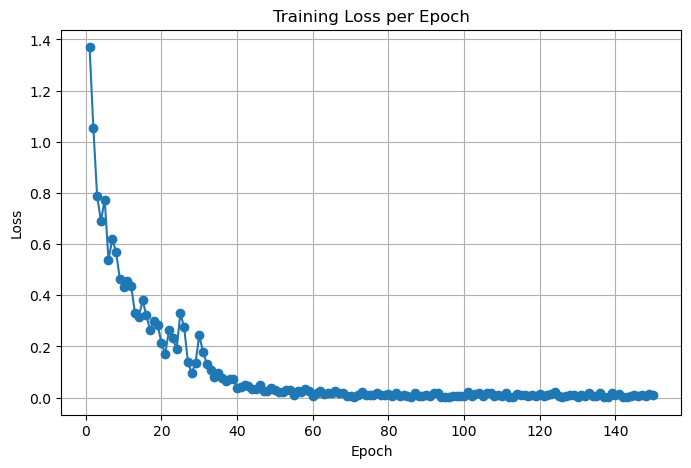


⏱️ Waktu training selesai dalam 763.27 detik (12.72 menit)


In [137]:
if __name__ == '__main__':
    start_time = time.time()
    
    train("S2_cnn_casia_c", CSV_TRAIN_S2)
    
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"\n⏱️ Waktu training selesai dalam {elapsed_time:.2f} detik "
          f"({elapsed_time/60:.2f} menit)")

In [12]:
if __name__ == '__main__':
    start_time = time.time()
    
    evaluate_condition("checkpoint_model_casia_c_v2/S2_cnn_casia_c_ep150(1).pth")
    
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"\n⏱️ Waktu training selesai dalam {elapsed_time:.2f} detik "
          f"({elapsed_time/60:.2f} menit)")

100%|████████████████████████████████████████| 106/106 [00:00<00:00, 289.60it/s]


Rank-1 Accuracy (fs): 0.9245
Rank-5 Accuracy (fs): 0.9623


100%|████████████████████████████████████████| 106/106 [00:00<00:00, 296.15it/s]


Rank-1 Accuracy (fq): 0.9528
Rank-5 Accuracy (fq): 0.9906


100%|████████████████████████████████████████| 106/106 [00:00<00:00, 295.46it/s]

Rank-1 Accuracy (fb): 0.9245
Rank-5 Accuracy (fb): 0.9623

⏱️ Waktu training selesai dalam 1.87 detik (0.03 menit)
